In [1]:
import networkx as nx

from regraph import Rule, plot_rule
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

In [2]:
g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin")

In [3]:
res = g.clear()

In [4]:
nodes = [
    ("a", {"name": "Jack", "age": 23, "hobby": {"hiking", "music"}}), 
    ("b", {"name": "Bob", "age": 24, "hobby": {"sport", "music"}}),
    "c", "d", "e", "f"
]
edges = [
    ("a", "b", {"type": {"friends", "colleagues"}}), 
    ("d", "b"), 
    ("a", "c"),
    ("e", "a"), 
    ("f", "d")
]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

In [5]:
g.add_node("x")

In [6]:
g.add_edge("x", "c")

In [7]:
g.remove_edge("x", "c")

In [8]:
g.remove_node("x")

In [9]:
g.nodes()

['a', 'b', 'c', 'd', 'e', 'f']

In [10]:
g.edges()

[('e', 'a'), ('d', 'b'), ('a', 'b'), ('a', 'c'), ('f', 'd')]

In [11]:
res_clone_1 = g.clone_node('a')
print("Created clone by the name: ", res_clone_1)

Created clone by the name:  a1


In [12]:
res_clone_1 = g.clone_node('a', ignore_naming=True)
print("Created clone by the name: ", res_clone_1)

Created clone by the name:  10708590


In [13]:
res_clone_2 = g.clone_node('a', 'a_clone')
print("Created clone by the name: ", res_clone_2)

Created clone by the name:  a_clone


In [14]:
res_merge = g.merge_nodes(["a", "b"])

In [15]:
res_merge

'a_b'

In [16]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y", "z", "a"])
pattern.add_edges_from([("x", "y"), ("y", "z"), ("z", "z"), ("z", "a")])

In [17]:
instances = g.find_matching(pattern)
print("Instances: ", instances)

Instances:  []


In [18]:
rule = Rule.from_transform(pattern)
clone_name1, _ = rule.inject_clone_node("y")
clone_name2, _ = rule.inject_clone_node("y")
rule.inject_remove_edge(clone_name2, "z")
rule.inject_remove_node("x")
rule.inject_merge_nodes(["y", "a"])
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "z")

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


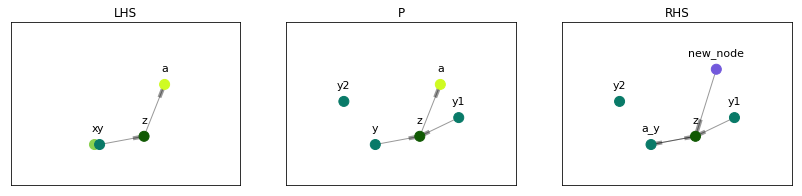

In [19]:
plot_rule(rule)

In [20]:
rhs_g = g.rewrite(rule, instances[0])
print("\n\nRewriting rule to commands: \n")
print(rule.to_commands())

IndexError: list index out of range

In [ ]:
rhs_g